# Lab | Data Aggregation and Filtering

In this challenge, we will continue to work with customer data from an insurance company. We will use the dataset called marketing_customer_analysis.csv, which can be found at the following link:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv

This dataset contains information such as customer demographics, policy details, vehicle information, and the customer's response to the last marketing campaign. Our goal is to explore and analyze this data by first performing data cleaning, formatting, and structuring.

1. Create a new DataFrame that only includes customers who have a total_claim_amount greater than $1,000 and have a response of "Yes" to the last marketing campaign.

In [3]:
import pandas as pd
url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
df = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv')

In [9]:
new_cols = [elem.lower().strip().replace(" ","_") for elem in df.columns]

new_cols[8] = 'employment_status'

df.columns = new_cols

In [96]:
type(df['total_claim_amount'][0])

numpy.float64

In [98]:
condition = [elem > 1000 for elem in df['total_claim_amount']]
df_tca = df[condition]
display(df_tca)

,unnamed:_0,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,...,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,vehicle_type
30,30,GX19342,California,8491.465719,No,Premium,High School or Below,1/28/11,Unemployed,F,...,0.0,3,Personal Auto,Personal L3,Offer1,Branch,1193.115879,Four-Door Car,Large,A
55,55,XQ74827,Arizona,19435.629240,No,Extended,High School or Below,2/1/11,Employed,F,...,0.0,3,Special Auto,Special L3,Offer1,Agent,2294.631639,Luxury Car,Medsize,A
74,74,LD75023,Oregon,26346.085820,No,Extended,High School or Below,1/20/11,Employed,M,...,0.0,2,Personal Auto,Personal L2,Offer1,Web,1605.600000,Luxury SUV,Medsize,NaN
77,77,YC54142,Washington,74228.516040,No,Extended,High School or Below,1/26/11,Unemployed,M,...,0.0,2,Personal Auto,Personal L1,Offer1,Branch,1742.400000,Luxury Car,Medsize,NaN
99,99,JY66887,California,16320.767160,No,Extended,High School or Below,2/27/11,Unemployed,F,...,3.0,5,Personal Auto,Personal L2,Offer2,Branch,1778.400000,Luxury Car,Medsize,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10874,10874,PD52748,NaN,10036.536340,NaN,Extended,High School or Below,2/12/11,Unemployed,F,...,1.0,8,Personal Auto,Personal L3,Offer1,Call Center,1353.289060,SUV,Medsize,NaN
10879,10879,FK95213,California,18611.453560,No,Extended,Master,1/16/11,Employed,F,...,0.0,7,Personal Auto,Personal L3,Offer2,Web,1021.654003,NaN,NaN,NaN
10900,10900,VN73653,Oregon,6423.739052,No,Basic,College,2/13/11,Unemployed,M,...,0.0,1,Corporate Auto,Corporate L2,Offer3,Agent,1621.560425,Luxury SUV,Medsize,NaN
10905,10905,FE99816,Nevada,15563.369440,No,Premium,Bachelor,1/19/11,Unemployed,F,...,NaN,7,Personal Auto,Personal L1,Offer3,Web,1214.400000,Luxury Car,Medsize,A


2. Using the original Dataframe, analyze the average total_claim_amount by each policy type and gender for customers who have responded "Yes" to the last marketing campaign. Write your conclusions.

In [163]:
tca_mean = df[df['response'] == 'Yes'].groupby(['policy_type','gender'])['total_claim_amount'].mean().round(2)
print(tca_mean)

policy_type     gender
Corporate Auto  F         433.74
                M         408.58
Personal Auto   F         452.97
                M         457.01
Special Auto    F         453.28
                M         429.53
Name: total_claim_amount, dtype: float64


In [165]:
# For corporate and special auto policies, women are charged a higher premium.
# For personal auto policies, women are charged less than men, though the values are close to one another.

3. Analyze the total number of customers who have policies in each state, and then filter the results to only include states where there are more than 500 customers.

In [35]:
grouped_2 = df.groupby(['state'])

counts = grouped_2['customer'].count()

filtered_counts = counts[counts > 500]

filtered_counts

state
Arizona       1937
California    3552
Nevada         993
Oregon        2909
Washington     888
Name: customer, dtype: int64

4. Find the maximum, minimum, and median customer lifetime value by education level and gender. Write your conclusions.

In [37]:
grouped_3 = df.groupby(['education','gender'])
grouped_3['customer_lifetime_value'].max()

education             gender
Bachelor              F         73225.95652
                      M         67907.27050
College               F         61850.18803
                      M         61134.68307
Doctor                F         44856.11397
                      M         32677.34284
High School or Below  F         55277.44589
                      M         83325.38119
Master                F         51016.06704
                      M         50568.25912
Name: customer_lifetime_value, dtype: float64

In [43]:
# Conclusions
#1 Customers at doctorate level have a lower max customer lifetime value than any other type. 
#2 While males educated to high school level and below have a high customer lifetime value, the maximum value for their female counterparts remains low 

In [39]:
grouped_3['customer_lifetime_value'].min()

education             gender
Bachelor              F         1904.000852
                      M         1898.007675
College               F         1898.683686
                      M         1918.119700
Doctor                F         2395.570000
                      M         2267.604038
High School or Below  F         2144.921535
                      M         1940.981221
Master                F         2417.777032
                      M         2272.307310
Name: customer_lifetime_value, dtype: float64

In [45]:
# Conclusions
#1 In contrast to the maximum levels, the customers educated to doctorate and masters level exhbit some of the highest minimum customer liftetime values.
#2 These two data points would suggest a correlation between a higher level of education and a smaller range in the customer lifetime value.

In [41]:
grouped_3['customer_lifetime_value'].median()

education             gender
Bachelor              F         5640.505303
                      M         5548.031892
College               F         5623.611187
                      M         6005.847375
Doctor                F         5332.462694
                      M         5577.669457
High School or Below  F         6039.553187
                      M         6286.731006
Master                F         5729.855012
                      M         5579.099207
Name: customer_lifetime_value, dtype: float64

In [111]:
# Conclusions
#1 The median values are well below 10,000, demonstrating that there are a significant number of high value outliers to each of the education levels.

In [47]:
import seaborn as sns

In [69]:
df['customer_lifetime_value'].describe()

count    10910.000000
mean      8018.241094
std       6885.081434
min       1898.007675
25%       4014.453113
50%       5771.147235
75%       8992.779137
max      83325.381190
Name: customer_lifetime_value, dtype: float64

In [81]:
import matplotlib as plt

<Axes: xlabel='education', ylabel='customer_lifetime_value'>

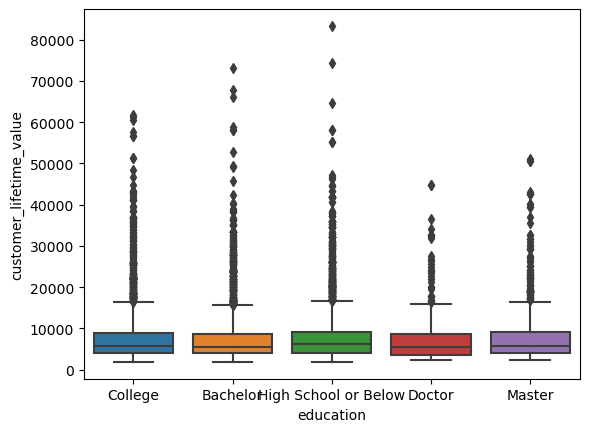

In [109]:
sns.boxplot(x = 'education', y = 'customer_lifetime_value', data = df,)

In [113]:
# The boxplots confirm the above conclusion that a large number of high value outliers skew the max values up but do not have a dramatic impact on median or mean. 
# Plots also confirm the lower variation among customers with doctor or master level education.

In [107]:
df['customer_lifetime_value'].describe()

count    10910.000000
mean      8018.241094
std       6885.081434
min       1898.007675
25%       4014.453113
50%       5771.147235
75%       8992.779137
max      83325.381190
Name: customer_lifetime_value, dtype: float64

## Bonus

5. The marketing team wants to analyze the number of policies sold by state and month. Present the data in a table where the months are arranged as columns and the states are arranged as rows.

In [229]:
months = ['01_Jan','02_Feb','03_Mar','04_Apr','05_May','06_Jun','07_Jul','08_Aug','09_Sep','10_Oct','11_Nov','12_Dec']
rev_months = list(reversed(months))*20
# Months since inception == 0 would return current month i.e. December.



In [231]:
start_month = [rev_months[i] for i in df['months_since_policy_inception']]

In [233]:
df['start_month'] = start_month

In [235]:
pivot = df.pivot_table(values = 'number_of_policies', columns ='start_month', index = 'state', aggfunc = 'count')
pivot

start_month,01_Jan,02_Feb,03_Mar,04_Apr,05_May,06_Jun,07_Jul,08_Aug,09_Sep,10_Oct,11_Nov,12_Dec
state,,,,,,,,,,,,
Arizona,170,145,173,163,161,138,156,164,201,166,138,162
California,325,285,272,267,300,284,294,267,316,313,304,325
Nevada,90,83,86,71,83,85,60,84,100,89,83,79
Oregon,255,236,217,246,229,213,222,221,261,287,286,236
Washington,66,58,64,90,74,68,78,64,103,79,74,70


6.  Display a new DataFrame that contains the number of policies sold by month, by state, for the top 3 states with the highest number of policies sold.

*Hint:*
- *To accomplish this, you will first need to group the data by state and month, then count the number of policies sold for each group. Afterwards, you will need to sort the data by the count of policies sold in descending order.*
- *Next, you will select the top 3 states with the highest number of policies sold.*
- *Finally, you will create a new DataFrame that contains the number of policies sold by month for each of the top 3 states.*

In [273]:
grouped_4 = df.groupby(['state'])
policy_total_by_state = grouped_4['number_of_policies'].sum().sort_values(ascending = False)
policy_total_by_state[0:3]

state
California    10602
Oregon         8666
Arizona        5916
Name: number_of_policies, dtype: int64

7. The marketing team wants to analyze the effect of different marketing channels on the customer response rate.

Hint: You can use melt to unpivot the data and create a table that shows the customer response rate (those who responded "Yes") by marketing channel.

External Resources for Data Filtering: https://towardsdatascience.com/filtering-data-frames-in-pandas-b570b1f834b9

In [ ]:
# your code goes here